In [1]:
import sys
sys.path.append('/Users/toma/Documents/Projects/taarifa-water-pumps')

In [2]:
import os
import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import clean as cl

In [3]:
def read_preprocess(x_path, y_path):
    repl = {'construction_year': {0: np.nan},
         'scheme_management': {'None': np.nan},
         'population': {0: np.nan}}

    df = pd.read_csv(x_path)
    if y_path:
        df_y = pd.read_csv(y_path)
        df = pd.merge(df, df_y, left_on='id', right_on='id', how='left')
#         df['status_group'] = df['status_group'].replace(target_encoding)
    df = df.replace(repl)

    df.date_recorded = pd.to_datetime(df.date_recorded, format="%Y-%m-%d")
    df['month_recorded'] = df.date_recorded.dt.month
    df['year_recorded'] = df.date_recorded.dt.year
    df['age_recorded'] = df.date_recorded.dt.year - df.construction_year
    df.loc[df.age_recorded < 0, 'age_recorded'] = np.nan
    df.permit = df.permit.replace({True: 'yes', False: 'no'})
    df.public_meeting = df.public_meeting.replace({True: 'yes', False: 'no'})
    
    cl.fe_funder(df, 'funder')
    cl.fe_installer(df, 'installer')
    cl.fe_scheme_name(df, 'scheme_name')

    return df

In [4]:
save_path = '/Users/toma/Documents/Projects/taarifa-water-pumps/data'
X_train = pd.read_csv(os.path.join(save_path, 'train_x.csv'))
y_train = pd.read_csv(os.path.join(save_path, 'train_y.csv'), names=["status"])

In [5]:
X = read_preprocess(os.path.join(save_path, 'train_x.csv'), os.path.join(save_path, 'train_y.csv'))

In [6]:
X.shape

(59400, 44)

In [7]:
categorical_features = list(X.select_dtypes(exclude=np.number).columns) + ['region_code', 'district_code']

In [8]:
numeric_features = [c for c in X.select_dtypes(include=np.number).columns if c not in categorical_features] 

In [9]:
numeric_features

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'population',
 'construction_year',
 'month_recorded',
 'year_recorded',
 'age_recorded']

Geo values for Tanzania region

In [12]:
min_long = 28.633
max_long =41.275
min_lat = -11.740
max_lat =  -0.874

In [13]:
lon_outl = 'longitude > @max_long or longitude < @min_long'
lat_outl = 'latitude < @min_lat or latitude > @max_lat'
geo_outl = lon_outl + ' or ' + lat_outl

In [14]:
X.query(geo_outl).shape

(1812, 44)

In [15]:
X['longitude_'] = X.longitude
X.loc[X.query(lon_outl).index, 'longitude_'] = np.nan

X['latitude_'] = X.latitude
X.loc[X.query(lat_outl).index, 'latitude_'] = np.nan

In [16]:
(100 * X.isnull().mean()).sort_values(ascending=False).head(10)

population           35.994949
age_recorded         34.878788
construction_year    34.863636
scheme_management     6.528620
public_meeting        5.612795
permit                5.144781
longitude_            3.050505
latitude_             3.050505
subvillage            0.624579
source_class          0.000000
dtype: float64

In [17]:
(100 * X.isnull().sum()).sort_values(ascending=False).head(10)

population           2138100
age_recorded         2071800
construction_year    2070900
scheme_management     387800
public_meeting        333400
permit                305600
longitude_            181200
latitude_             181200
subvillage             37100
source_class               0
dtype: int64

In [18]:
import missingno as msno

In [19]:
missing_cols = ['population', 'construction_year', 'scheme_management', 'public_meeting', 'permit', 
              'longitude_', 'latitude_', 'subvillage']

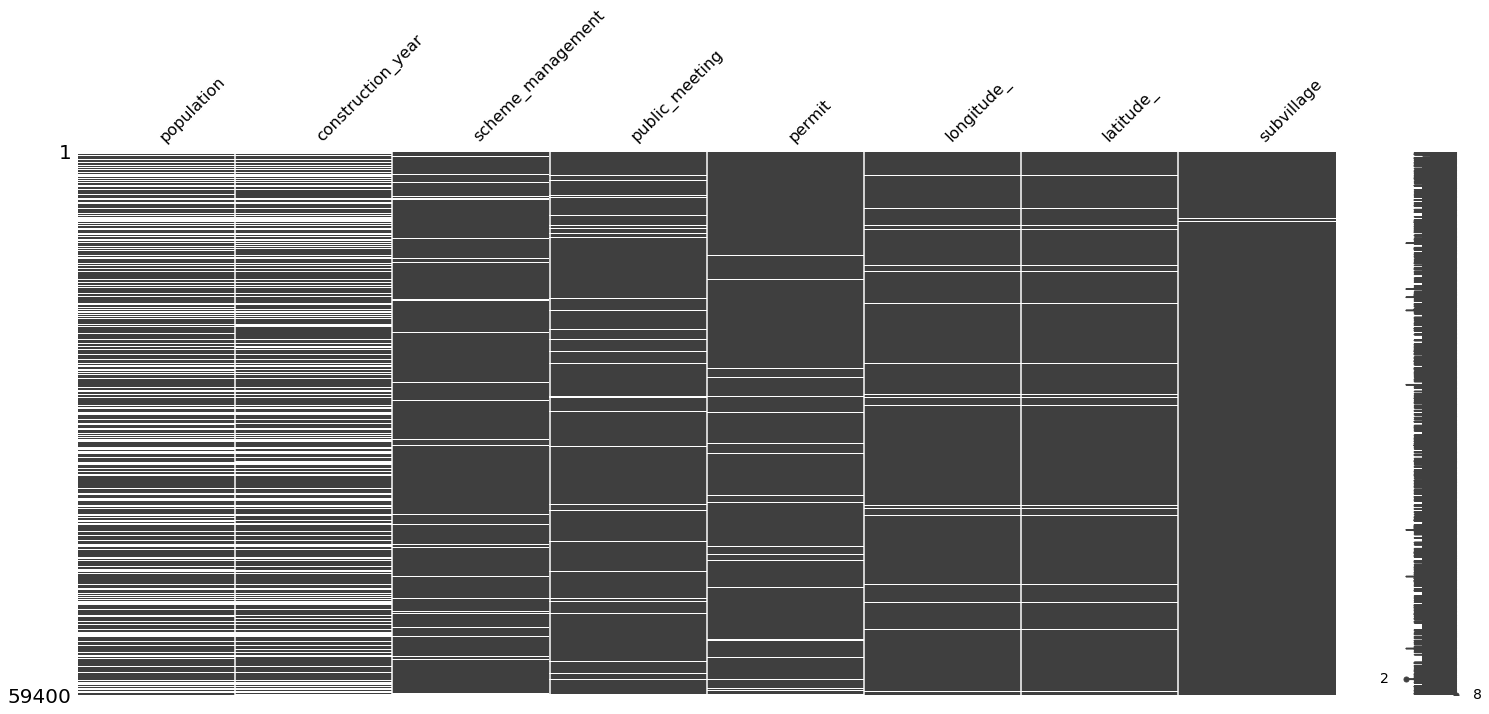

In [20]:
msno.matrix(X[missing_cols])

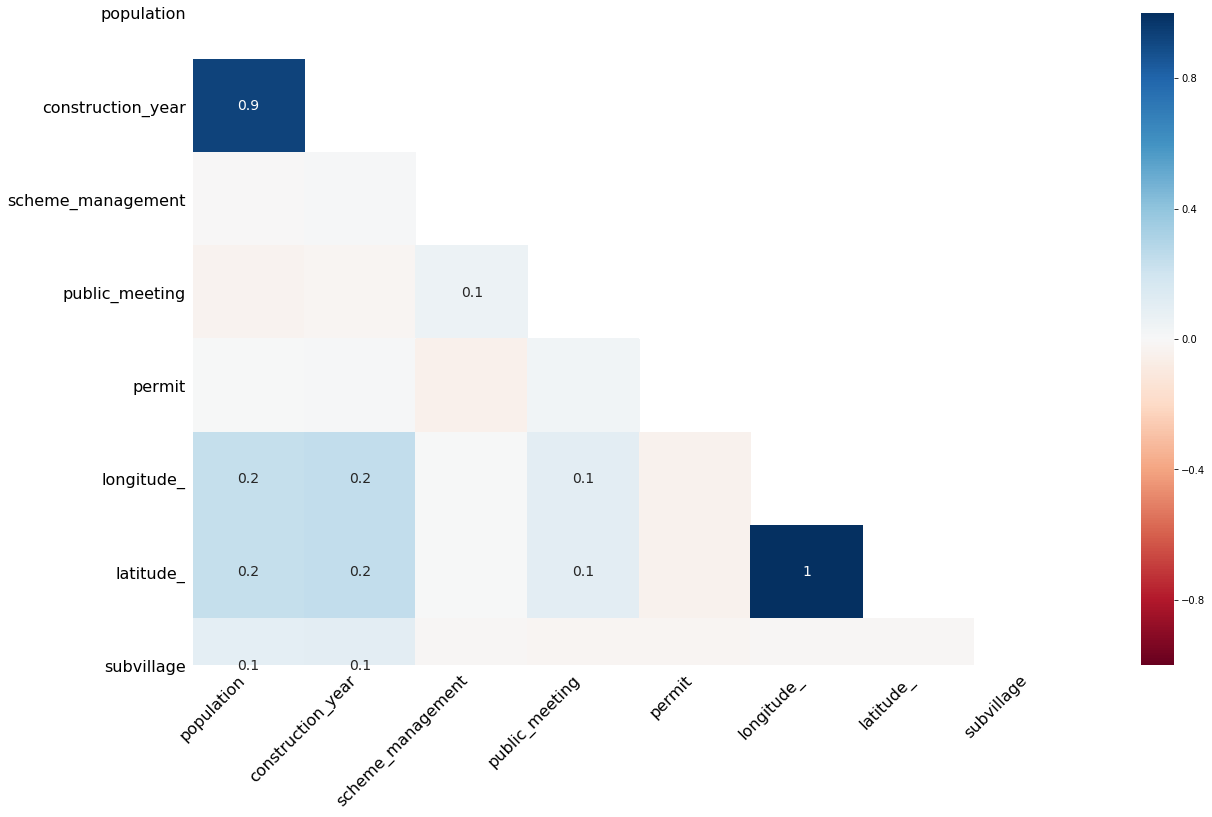

In [21]:
msno.heatmap(X[missing_cols])

In [22]:
X[missing_cols].isnull().corr()

,population,construction_year,scheme_management,public_meeting,permit,longitude_,latitude_,subvillage
population,1.000000,0.925894,-0.004385,-0.033231,0.001428,0.236537,0.236537,0.101264
construction_year,0.925894,1.000000,0.010438,-0.020621,0.010166,0.242459,0.242459,0.103878
scheme_management,-0.004385,0.010438,1.000000,0.058132,-0.048901,0.003448,0.003448,-0.014032
public_meeting,-0.033231,-0.020621,0.058132,1.000000,0.032935,0.109006,0.109006,-0.018404
permit,0.001428,0.010166,-0.048901,0.032935,1.000000,-0.041311,-0.041311,-0.018463
longitude_,0.236537,0.242459,0.003448,0.109006,-0.041311,1.000000,1.000000,-0.014063
latitude_,0.236537,0.242459,0.003448,0.109006,-0.041311,1.000000,1.000000,-0.014063
subvillage,0.101264,0.103878,-0.014032,-0.018404,-0.018463,-0.014063,-0.014063,1.000000


In [23]:
miss = X[missing_cols].isnull()

In [24]:
miss = pd.merge(miss, X[[c for c in X.columns if c not in missing_cols]], left_index=True,
               right_index=True)

In [25]:
from dython.nominal import associations

Next we check dependence between the fact that the variable is missing with a few other variables in the
data set

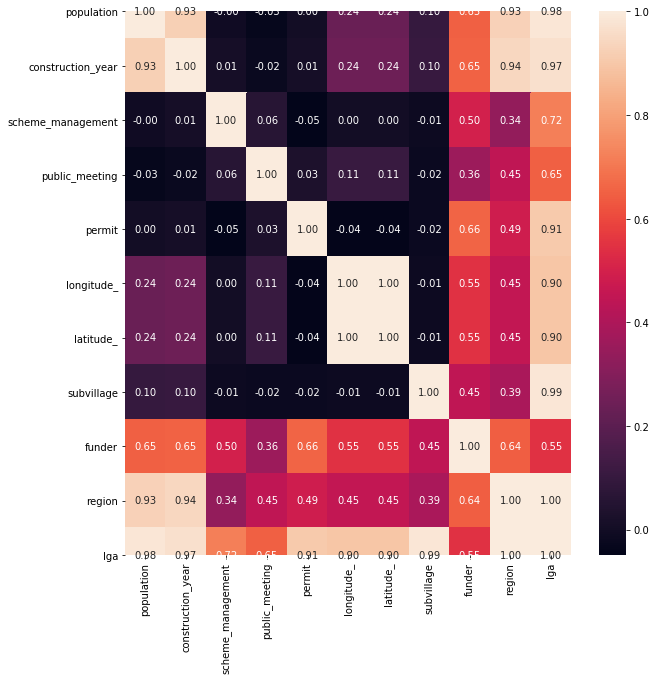

In [26]:
associations(miss[missing_cols + ['funder', 'region',  'lga', ]].copy(), 
             nominal_columns=['funder', 'region', 'lga'],
            figsize=(10,10))

### Imputing strategy for geo data

In [27]:
X['longitude_miss'] = X.longitude_.isnull()

In [28]:
count_miss = lambda s: s.isnull().sum()

In [29]:
s = X.groupby(['region','lga'])[['longitude_', 'latitude_']].agg(['mean', 'std', 'size', count_miss]) 
s.columns = ['ln_mean', 'ln_std', 'ln_count', 'ln_nb_miss',
            'lt_mean', 'lt_std', 'lt_count', 'lt_nb_miss']
# s[s.nb_miss>0]
s.query('ln_nb_miss>0 or lt_nb_miss>0')

ln_mean    ln_std  ln_count  ln_nb_miss   lt_mean  \
region    lga                                                            
Mwanza    Geita          NaN       NaN       488       488.0       NaN   
          Magu     33.282024  0.227722       824       319.0 -2.568506   
Shinyanga Bariadi  34.179476  0.120967      1177      1005.0 -2.962381   

                     lt_std  lt_count  lt_nb_miss  
region    lga                                      
Mwanza    Geita         NaN       488       488.0  
          Magu     0.090723       824       319.0  
Shinyanga Bariadi  0.046255      1177      1005.0

In [31]:
s = X.groupby(['region'])[['longitude_', 'latitude_']].agg(['mean', 'std', 'size', count_miss]) 
s.columns = ['ln_mean', 'ln_std', 'ln_count', 'ln_nb_miss',
            'lt_mean', 'lt_std', 'lt_count', 'lt_nb_miss']
# s[s.nb_miss>0]
s.query('ln_nb_miss>0 or lt_nb_miss>0')

,ln_mean,ln_std,ln_count,ln_nb_miss,lt_mean,lt_std,lt_count,lt_nb_miss
region,,,,,,,,
Mwanza,33.091564,0.329287,3102,807.0,-2.620502,0.329898,3102,807.0
Shinyanga,33.240121,0.765545,4982,1005.0,-3.495696,0.328573,4982,1005.0


In [32]:
X.shape

(59400, 47)

In [33]:
def inpute_geo(X):
    min_long = 28.633
    max_long =41.275
    min_lat = -11.740
    max_lat =  -0.874

    lon_outl = 'longitude > @max_long or longitude < @min_long'
    lat_outl = 'latitude < @min_lat or latitude > @max_lat'
    geo_outl = lon_outl + ' or ' + lat_outl
    
    
    X.loc[X.query(lon_outl).index, 'longitude'] = np.nan
    X.loc[X.query(lat_outl).index, 'latitude'] = np.nan
    
    ln_lga = X.groupby('lga').longitude.agg(['median', 'count'])
    ln_region = X.groupby('region').longitude.agg(['median', 'count'])
    lt_lga = X.groupby('lga').latitude.agg(['median', 'count'])
    lt_region = X.groupby('region').latitude.agg(['median', 'count'])
    
    d = X[['region', 'lga', 'longitude', 'latitude']].copy()
    d = pd.merge(d, ln_lga, how='left', left_on='lga', right_index=True).rename(columns={'median': 'ln_lga_med',
                                                                                        'count': 'ln_lga_nb'})
    d = pd.merge(d, ln_region, how='left', left_on='region', right_index=True).rename(columns={'median': 'ln_rg_med',
                                                                                        'count': 'ln_rg_nb'})
    
    d = pd.merge(d, lt_lga, how='left', left_on='lga', right_index=True).rename(columns={'median': 'lt_lga_med',
                                                                                        'count': 'lt_lga_nb'})
    
    d = pd.merge(d, lt_region, how='left', left_on='region', right_index=True).rename(columns={'median': 'lt_rg_med',
                                                                                        'count': 'lt_rg_nb'})
    
    d['ln_fill'] = d.ln_lga_med.where(d.ln_lga_nb>10, d.ln_rg_med)
    d['lt_fill'] = d.lt_lga_med.where(d.lt_lga_nb>10, d.lt_rg_med) 
    
    
    X.longitude = X.longitude.fillna(d.ln_fill)
    X.latitude = X.latitude.fillna(d.lt_fill)
    
    return X
    
    
    

In [34]:
X_cl, d = inpute_geo(X)

In [35]:
d.head()

,region,lga,longitude,latitude,ln_lga_med,ln_lga_nb,ln_rg_med,ln_rg_nb,lt_lga_med,lt_lga_nb,lt_rg_med,lt_rg_nb,ln_fill,lt_fill
0,Iringa,Ludewa,34.938093,-9.856322,34.678659,564,34.775052,5294,-9.831755,564,-9.079441,5294,34.678659,-9.831755
1,Mara,Serengeti,34.698766,-2.147466,34.515953,716,34.137821,1969,-1.797177,716,-1.771854,1969,34.515953,-1.797177
2,Manyara,Simanjiro,37.460664,-3.821329,37.013464,308,35.653555,1583,-3.690670,308,-4.224828,1583,37.013464,-3.690670
3,Mtwara,Nanyumbu,38.486161,-11.155298,38.456683,158,39.374870,1730,-10.976995,158,-10.708706,1730,38.456683,-10.976995
4,Kagera,Karagwe,31.130847,-1.825359,30.952440,771,31.357266,3316,-1.472080,771,-1.740384,3316,30.952440,-1.472080


### Missing values of population and construction year

In [181]:
s = X.groupby(['region'])[['population']].agg(['median', 'std', 'size', count_miss]) 
s = s.rename(columns={'<lambda_0>': 'nb_miss'}, level=1)
s[s['population']['nb_miss']>0]


population                          
              median         std  size nb_miss
region                                        
Arusha         150.0  442.733646  3350     1.0
Dodoma           NaN         NaN  2201  2201.0
Iringa          54.0  207.994290  5294  1164.0
Kagera           NaN         NaN  3316  3316.0
Kigoma         360.0  590.972462  2816    31.0
Mbeya            NaN         NaN  4639  4639.0
Mwanza         400.0  493.794049  3102  2735.0
Pwani           50.0  970.509564  2635     1.0
Rukwa          200.0  750.746680  1808    47.0
Ruvuma         100.0  483.515680  2640   467.0
Shinyanga      500.0  224.024946  4982  4818.0
Singida        200.0  494.377984  2093     2.0
Tabora           NaN         NaN  1959  1959.0

Global median

In [180]:
X.population.median()

150.0

In [40]:
s = X.groupby(['region'])[['construction_year']].agg(['median', 'min', 'max', 'std', 'size', count_miss]) 
s = s.rename(columns={'<lambda_0>': 'nb_miss'}, level=1)
s[(s['construction_year']['median']>0) & (s['construction_year']['nb_miss']>0)].\
                sort_values(('construction_year', 'nb_miss'), ascending=False )


construction_year                                         
                         median     min     max        std  size nb_miss
region                                                                  
Shinyanga                2005.0  1985.0  2012.0   5.762456  4982  4818.0
Mwanza                   1996.0  1963.0  2011.0  11.245977  3102  2747.0
Iringa                   2000.0  1964.0  2011.0  11.488838  5294   372.0
Pwani                    2007.0  1964.0  2011.0   9.986162  2635   176.0
Lindi                    1997.0  1960.0  2013.0  13.656049  1546   113.0
Tanga                    1996.0  1960.0  2011.0  14.658288  2547    94.0
Mtwara                   1988.0  1966.0  2013.0  13.297554  1730    87.0
Arusha                   2001.0  1960.0  2013.0  11.915853  3350    51.0
Kilimanjaro              2002.0  1960.0  2013.0  14.748032  4379    35.0
Morogoro                 1997.0  1960.0  2011.0  11.629409  4006    18.0
Dar es Salaam            2000.0  1960.0  2010.0  11.041489   805    17.0
Mara                     1998.0  1960.0  2012.0  11.537118  1969    17.0
Ruvuma                   1997.0  1968.0  2013.0  10.002448  2640    16.0
Manyara                  2004.0  1964.0  2013.0   9.803441  1583    13.0
Kigoma                   2001.0  1966.0  2013.0  10.822891  2816    10.0
Singida                  2000.0  1960.0  2012.0  13.520203  2093     8.0
Rukwa                    1988.0  1965.0  2012.0  10.459128  1808     2.0

Global median

In [42]:
X.construction_year.median()

2000.0